# Documented Code

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
#import cvxpy as cp
from matplotlib.colors import LogNorm
from scipy.special import erf, gamma
from scipy.linalg import eigvals, eigh
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import gc
import warnings



def get_optimal_device() -> torch.device:
    """
    Determine the optimal computational device for PyTorch operations.
    Returns:
        torch.device: The best available device in order of preference:
                     1. CUDA (Nvidia GPUs)
                     2. MPS (Apple Silicon GPUs)
                     3. CPU (fallback)
    """
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Set torch device for hardware acceleration
device = get_optimal_device()
device

device(type='cuda')

In [3]:
# Helper Functions
def estimate_forward_KL(X, flow, log_rho_exact):
    # Compute log-density under the exact model and flow estimate
    log_ex = log_rho_exact(X)
    log_est = flow.log_prob(X)
    # Monte Carlo Estimate
    kl_mc = np.mean(log_ex - log_est)
    return kl_mc

def preconditioned_CG(A, b, M_inv, x0=None, tol=1e-6, max_iter=1000):
    """
    Solves Ax = b using the Preconditioned Conjugate Gradient (PCG) method.
    A needs to be symmetric positive-definite, which is the case for the Hessian at local minima.

    Args:
        A (np.ndarray): The symmetric positive-definite matrix.
        b (np.ndarray): The right-hand side vector.
        M_inv (np.ndarray or function): The inverse of the preconditioner matrix,
                                        or a function that computes M_inv @ r.
        x0 (np.ndarray, optional): Initial guess for the solution. Defaults to zeros.
        tol (float, optional): Tolerance for convergence.
        max_iter (int, optional): Maximum number of iterations.

    Returns:
        np.ndarray: The solution vector x.
    """
    n = len(b)

    # Initialize solution vector x
    if x0 is None:
        x = np.zeros(n)
    else:
        x = x0

    # Initial residual (r = b - Ax)
    r = b - A @ x
    
    # Apply the preconditioner: z = M^{-1}r
    # This is the key difference from standard CG
    if callable(M_inv):
        z = M_inv(r)
    else:
        z = M_inv @ r
    
    # Initial search direction (p = z)
    p = z.copy()
    
    # Dot product for later use
    rz_old = np.dot(r, z)

    for i in range(max_iter):
        # Calculate matrix-vector product Ap
        Ap = A @ p
        
        # Calculate step size alpha
        alpha = rz_old / np.dot(p, Ap)
        
        # Update solution: x_{k+1} = x_k + alpha * p_k
        x = x + alpha * p
        
        # Update residual: r_{k+1} = r_k - alpha * Ap_k
        r_new = r - alpha * Ap
        
        # Check for convergence using the norm of the unpreconditioned residual
        if np.linalg.norm(r_new) < tol:
            print(f"Converged after {i+1} iterations.")
            break
            
        # Apply the preconditioner: z_{k+1} = M^{-1}r_{k+1}
        if callable(M_inv):
            z_new = M_inv(r_new)
        else:
            z_new = M_inv @ r_new
        
        # Calculate new dot product
        rz_new = np.dot(r_new, z_new)
        
        # Update search direction: p_{k+1} = z_{k+1} + beta * p_k
        beta = rz_new / rz_old
        p = z_new + beta * p
        
        # Update variables for next iteration
        r = r_new
        z = z_new
        rz_old = rz_new
    else:
        print("Did not converge within the maximum number of iterations.")

    return x

In [4]:
# ICNN model class

class ICNN(nn.Module):
    def __init__(self, n_dim, hidden_dims, alpha=1.0):
        """
        Initializes the ICNN.

        Args:
            n_dim (int): The output dimension.
            hidden_dims (list:ints): Dimensions of hidden layers.
            alpha (float): The length-scale of the model.
        """
        super(ICNN, self).__init__()
        self.n_dim = n_dim
        self.hidden_dims = hidden_dims
        self.alpha = 1.0

        self.Wx_layers = nn.ModuleList()
        self.Wz_layers = nn.ModuleList()
        self.b = nn.ParameterList()


        prev_dim = 0
        for idx, hidden_dim in enumerate(hidden_dims):
            wx = nn.Linear(n_dim, hidden_dim)
            wz = nn.Linear(prev_dim, hidden_dim)

            if idx == 0:
                with torch.no_grad():
                    wz.weight.zero_()

            self.Wx_layers.append(wx)
            self.Wz_layers.append(wz)
            self.b.append(nn.Parameter(torch.zeros(hidden_dim)))

            prev_dim = hidden_dim
        self.output_layer = nn.Linear(hidden_dims[-1], 1, bias=False)

    def forward(self, x):
        z = None
        quadratic_term = self.alpha / 2 * torch.sum(x ** 2, dim=-1, keepdim=True)
        for i in range(len(self.hidden_dims)):
            wx_x = self.Wx_layers[i](x)
            if i == 0:
                linear_sum = wx_x + self.b[i]
            else:
                wz_z = self.Wz_layers[i](z)
                linear_sum = wx_x + wz_z + self.b[i]
            z = F.softplus(linear_sum)

        output = quadratic_term + self.output_layer(z)
        return output

    def enforce_constraints(self):
        """
        Enforces the non-negativity constraint on W^(z) weights and output layer.
        This should be called after the optimizer.step() during training.
        """
        with torch.no_grad():
            for i in range(1, len(self.Wz_layers)):
                self.Wz_layers[i].weight.copy_(torch.abs(self.Wz_layers[i].weight))
            # Ensure output layer weights are also non-negative
            self.output_layer.weight.copy_(torch.abs(self.output_layer.weight))
        

In [62]:


class DeepConvexFlow(torch.nn.Module):
    """
    Deep convex potential flow parameterized by an input-convex neural network
    """

    def __init__(self, icnn, dim, n_icnns=3, unbiased=False, no_bruteforce=True, m1=10, m2=None, rtol=0.0, atol=1e-3,
                 bias_w1=0.0, trainable_w0=True):
        super(DeepConvexFlow, self).__init__()
        if m2 is None:
            m2 = dim
        
        # Create multiple ICNNs if n_icnns > 1, otherwise keep single ICNN
        if n_icnns > 1:
            self.icnn = nn.ModuleList([icnn for _ in range(n_icnns)])
            # Create separate beta parameters for each ICNN
            self.beta = nn.Parameter(torch.zeros(n_icnns) + bias_w1)
        else:
            self.icnn = icnn
            self.beta = nn.Parameter(torch.zeros(1) + bias_w1)
        
        self.n_icnns = n_icnns
        self.no_bruteforce = no_bruteforce
        self.rtol = rtol
        self.atol = atol

        self.w0 = torch.nn.Parameter(torch.log(torch.exp(torch.ones(1)) - 1), requires_grad=trainable_w0)
        # Keep w1 for backward compatibility or remove if not needed
        self.w1 = torch.nn.Parameter(torch.zeros(1) + bias_w1)
        self.bias_w1 = bias_w1

        self.m1, self.m2 = m1, m2
    
    def _flatten(self, t):
        return t.view(t.size(0), -1)

    def _rademacher_like(self, x):
        return (torch.randint_like(x, low=0, high=2) * 2 - 1).to(x)

    def _hvp(self, x, u, centers=None, create_graph=False):
        """
        Hessian-vector product Hu with H = ∇^2_x Fθ(x).
        """
        x_req = x.clone().requires_grad_(True)
        F = self.get_potential(x_req, centers=centers)                 # (B,1)
        g = torch.autograd.grad(F.sum(), x_req, create_graph=create_graph)[0]  # ∇F
        dot = (self._flatten(g) * self._flatten(u)).sum()              # scalar
        Hu = torch.autograd.grad(dot, x_req, create_graph=create_graph)[0]     # H u
        return Hu

    @torch.no_grad()
    def _cg_solve(self, x, b, centers=None, iters=25, tol=1e-6, damping=1e-4):
        """
        Solve (H + λI) z = b using CG with Hessian-vector products. No autograd graph kept.
        λ>0 (damping) stabilizes early training.
        """
        z = torch.zeros_like(b)

        def A(v):
            return self._hvp(x, v, centers=centers, create_graph=False) + damping * v

        r = b - A(z)
        p = r.clone()

        def bdot(a, c):
            return (self._flatten(a) * self._flatten(c)).sum(dim=1, keepdim=True)  # (B,1)

        rs = bdot(r, r)  # (B,1)
        for _ in range(iters):
            Ap = A(p)
            denom = bdot(p, Ap) + 1e-12
            alpha = rs / denom
            z = z + alpha * p
            r = r - alpha * Ap
            rs_new = bdot(r, r)
            # (optional early stop could be added per element using rs_new.sqrt() < tol)
            beta = rs_new / (rs + 1e-12)
            p = r + beta * p
            rs = rs_new
        return z

    def _logdet_grad_surrogate(self, x, centers=None, K=1, cg_iters=25, damping=1e-4):
        """
        Returns a scalar L such that ∇θ L = ∇θ [ (1/B) Σ_b log det H(x_b) ].
        """
        B = x.size(0)
        acc = 0.0
        for _ in range(K):
            v = self._rademacher_like(x)                       # v ~ Rademacher
            z = self._cg_solve(x, v, centers=centers, iters=cg_iters, damping=damping)  # z ≈ H^{-1} v
            z = z.detach()                                     # stop grad through solver
            Hz_theta = self._hvp(x, z, centers=centers, create_graph=True)              # track θ here
            # E_v[ v^T (∂H/∂θ) H^{-1} v ]  → gradient of log det
            acc = acc + (self._flatten(Hz_theta) * self._flatten(v)).sum() / B          # scalar
        return acc / K
        
    def get_potential(self, x, centers=None):
        n = x.size(0)
        
        if self.n_icnns > 1:
            # Weighted sum of multiple ICNNs with individual beta weights
            icnn_weighted_sum = 0
            for i, icnn in enumerate(self.icnn):
                if centers is None:
                    icnn_output = icnn(x)
                else:
                    icnn_output = icnn(x - centers[i])  # Shift input by center for each ICNN
                icnn_weighted_sum += F.softplus(self.beta[i]) * icnn_output
        else:
            # Single ICNN case
            if centers is None:
                icnn_output = self.icnn(x)
            else:
                icnn_output = self.icnn(x - centers[0])
            icnn_weighted_sum = F.softplus(self.beta[0]) * icnn_output
        
        return icnn_weighted_sum + F.softplus(self.w0) * (x.view(n, -1) ** 2).sum(1, keepdim=True) / 2

    def reverse(self, y, max_iter=1000000, lr=1.0, tol=1e-12, x=None, centers=None, **kwargs):
        if x is None:
            x = y.clone().detach().requires_grad_(True)

        def closure():
            # Solves x such that f(x) - y = 0
            # <=> Solves x such that argmin_x F(x) - <x,y>
            F = self.get_potential(x, centers=centers)
            loss = torch.sum(F) - torch.sum(x * y)
            x.grad = torch.autograd.grad(loss, x)[0].detach()
            return loss

        optimizer = torch.optim.LBFGS([x], lr=lr, line_search_fn="strong_wolfe", max_iter=max_iter, tolerance_grad=tol,
                                      tolerance_change=tol)

        optimizer.step(closure)

        error_new = (self.forward_transform(x, centers=centers)[0] - y).abs().max().item()
        # if error_new > math.sqrt(tol):
        #     print('inversion error', error_new, flush=True)
        torch.cuda.empty_cache()
        gc.collect()

        return x

    def forward(self, x, centers=None):
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x, centers=centers)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]
        return f

    def forward_transform(self, x, logdet=0, centers=None, extra=None):

        return self.forward_transform_bruteforce(x, logdet, centers=centers)
    
    def forward_transform_fast(self, x, logdet=0.0, centers=None, use_unbiased_logdet=False,
                      K=1, cg_iters=25, damping=1e-4):
        """
        If use_unbiased_logdet=False: fall back to brute-force Hessian + exact slogdet (your current path).
        If True: return (y, logdet_grad_surrogate) instead of the exact logdet value.
        """
        if not use_unbiased_logdet:
            return self.forward_transform_bruteforce(x, logdet, centers=centers)

        # y = ∇F
        with torch.enable_grad():
            x = x.clone().requires_grad_(True)
            F = self.get_potential(x, centers=centers)
            y = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

        # Hutchinson + CG: a scalar whose gradient is ∇θ log det H
        logdet_grad = self._logdet_grad_surrogate(
            x, centers=centers, K=K, cg_iters=cg_iters, damping=damping
        )
        return y, logdet_grad


    def forward_transform_bruteforce(self, x, logdet=0, centers=None):
        warnings.warn('brute force')
        bsz = x.shape[0]
        input_shape = x.shape[1:]

        with torch.enable_grad():
            x.requires_grad_(True)
            F = self.get_potential(x, centers=centers)
            f = torch.autograd.grad(F.sum(), x, create_graph=True)[0]

            # TODO: compute Hessian in block mode instead of row-by-row.
            f = f.reshape(bsz, -1)
            H = []
            for i in range(f.shape[1]):
                retain_graph = self.training or (i < (f.shape[1] - 1))
                H.append(
                    torch.autograd.grad(f[:, i].sum(), x, create_graph=self.training, retain_graph=retain_graph)[0])

            # H is (bsz, dim, dim)
            H = torch.stack(H, dim=1)

        f = f.reshape(bsz, *input_shape)
        return f, logdet + torch.slogdet(H).logabsdet

    def extra_repr(self):
        return f"ConjGrad(rtol={self.rtol}, atol={self.atol})"
    
    def log_prob(self, x):
        x = torch.tensor(x, device=device, dtype=torch.float32)
        y, logdet = self.forward_transform(x, logdet=0.0)
        base_logprob = -0.5 * torch.sum(y ** 2, dim=1) - (x.shape[1] / 2) * np.log(2 * np.pi)
        return (base_logprob + logdet).detach().cpu().numpy()


In [68]:
N_ICNNS = 3
icnn = ICNN(n_dim=2, hidden_dims=[8, 16, 32, 16, 8]).to(device)
model = DeepConvexFlow(icnn, 2, n_icnns=N_ICNNS).to(device)

def train(X, model, epochs=200, lr=5e-2, dim=2, log_rho_exact=None):
    EPOCHS = epochs
    LR=lr
    base = torch.distributions.MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
    centers = None


    for epoch in range(1, EPOCHS + 1):
        total_loss = 0.0
        for (x_batch,) in dataloader:
            x_batch = x_batch.to(device)
            #choose random points from the data and assign them to centers (match the number of ICNNs if multiple)
            

            y, logdet = model.forward_transform(x_batch, centers=centers, logdet=0.0)
            logp0 = base.log_prob(y)
            logpx = logp0 + logdet

            loss = -logpx.mean()  # NLL = reverse KL

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if hasattr(model.icnn, '__iter__'):  # Multiple ICNNs case
                for icnn in model.icnn:
                    icnn.enforce_constraints()
            else:  # Single ICNN case
                model.icnn.enforce_constraints()



            total_loss += loss.item() * x_batch.size(0)
        
        scheduler.step()
        KL = estimate_forward_KL(X, model, log_rho_exact)

        
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{EPOCHS}, NLL = {total_loss/len(X):.4f}, KL = {KL:.4f}")
    return centers



In [24]:
# RBF Convex Flow class

class RBFConvexFlow:
    def __init__(self, n_p=50, epsilon=0.5):
        """
        Initializes the density estimator.

        Args:
            n_p (int): The number of points each local map should influence.
                       This controls the resolution or "bandwidth" of the estimate.
                       The default is 50.
            epsilon (float): The maximum step size for the parameter of each map.
                             This caps the learning rate to ensure stability.
                             The default is 0.5.
        """
        self.n_p = n_p
        self.epsilon = epsilon
        # Empty lists to store map parameters and KL divergence for each iteration
        self.maps = []
        self.preconditioning = {}
        self.kl_history = []
        self.l2cost = np.nan

    def _volume_n_ball(self, n, radius=1):
        """
        Calculates the volume of an n-ball with the specified radius,
        or a unit ball if radius is not given.

        Args:
            n (int): The dimension of the n-ball.
            radius (float): The radius of the n-ball.
        """
        return radius**n * np.pi**(n/2) / gamma(n/2 + 1)

    def _calculate_alpha(self, x0, n, m):
        """
        Calculates the bandwidth alpha given a center x0, m number of points arround x0, in n dimensions.

        Args:
            x0 (float): Center of the unit n-ball
            n (int): The dimension of the points.
            m (int): Number of points around x0 to be influenced by alpha.
        """
        omega_n = self._volume_n_ball(n)
        alpha = (2 * np.pi)**0.5 * (omega_n**-1 * self.n_p / m)**(1/n) * np.exp(np.linalg.norm(x0)**2 / (2*n))
        return alpha

    def _radial_f(self, r, alpha):
        """
        The radial localization function f(r), based on equation (24).
        Handles the r=0 case to avoid division by zero.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the localization function.
        """
        # Handle r=0 separately to avoid division by zero.
        # The limit of erf(x)/x as x->0 is 2/sqrt(pi).
        f_vals = np.zeros_like(r)
        nonzero_r = r != 0
        zero_r = ~nonzero_r

        r_scaled = r[nonzero_r] / alpha
        f_vals[nonzero_r] = erf(r_scaled) / r[nonzero_r]
        f_vals[zero_r] = 2.0 / (alpha * np.sqrt(np.pi))
        return f_vals

    def _radial_f_prime(self, r, alpha):
        """
        The derivative of the radial localization function, f'(r).
        Handles the r=0 case, where the derivative is 0.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the derivative.
        """
        f_prime_vals = np.zeros_like(r)
        nonzero_r = r != 0
        
        r_nz = r[nonzero_r]
        r_scaled = r_nz / alpha
        
        term1 = (2.0 / (alpha * np.sqrt(np.pi))) * np.exp(-r_scaled**2)
        term2 = erf(r_scaled) / r_nz
        f_prime_vals[nonzero_r] = (term1 - term2) / r_nz
        
        return f_prime_vals

    def compute_J_prime(self, m, n, diff, r, f, f_prime):
        # Initialize output array
        J_prime = np.zeros((m, n, n))

        # Create mask for non-zero r values
        mask = r != 0

        # Add scaled identity matrices where mask is True
        J_prime[mask] = f[mask, None, None] * np.eye(n)

        # Compute scaling factors for outer product (f_prime[i]/r[i])
        scale = np.zeros(m)
        scale[mask] = f_prime[mask] / r[mask]

        # Compute outer products: (diff[i] @ diff[i].T) for all i, scaled by scale[i]
        outer_products = np.einsum('mi,mj->mij', diff, diff)
        J_prime += scale[:, None, None] * outer_products
        return J_prime


    def fit(self, x, log_rho_exact=None, n_steps=1000):
        """
        Fits the density model to the data by building a sequence of maps.
        """
        m, n = x.shape

        # Starting map

        # I choose to incorporate the preconditioning here because composing the preconditioning map will not impact the convexity of the primitive function.
        mean = np.mean(x, axis=0)
        z0 = x - mean
        std = np.sqrt(np.mean(np.sum(z0**2, axis=1)) / n)
        z0 /= std

        z = z0.copy()

        self.preconditioning = {'mean': mean, 'std': std}
        self.maps = []


        # This is the Jacobian matrix at each point. I initialize the matrix to the identity. We assume the Jacobian is always invertible, otherwise we cannot determine the target probability density.
        J = np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))

        # Iterative map building
        for i in range(n_steps):
            # 1. Select a center x0
            if np.random.rand() > 0.5:
                # Pick from the actual observations at their current normalized state
                idx = np.random.randint(m)
                x0 = z[idx]
            else:
                # Sample the target normal distribution to keep x0 from becoming too large
                x0 = np.random.randn(n)

            # 2. Calculate length-scale alpha
            alpha = self._calculate_alpha(x0, n, m)

            # 3. Calculate Gradient (G) of the log likelihood.
            diff = z0-x0
            r = np.linalg.norm(diff, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)
            J_prime = self.compute_J_prime(m, n, diff, r, f, f_prime)
            J_inverse = np.linalg.inv(J)
            term_1 = np.einsum('kii->k', J_inverse @ J_prime)
            term_2 = -f*np.sum(z * diff, axis=1)
            G = np.sum(term_1 + term_2)



            # 4. Calculate optimal step beta and constrain it
            v = self.epsilon/(np.sqrt(self.epsilon**2+G**2))
            beta = v*G

            # 5. Update the Jacobian
            J = J+beta*J_prime

            # 6. Apply the map to transform the data
            z = z + beta * f[:, np.newaxis] * (z0 - x0)


            # 7. Store the map's parameters
            self.maps.append({'x0': x0, 'alpha': alpha, 'beta': beta})

            if log_rho_exact is not None:
                # Estimate the KL divergence if the exact log density is provided
                kl = estimate_forward_KL(x, self, log_rho_exact)
                self.kl_history.append(kl)

            if (i+1) % (n_steps//10) == 0:
                if log_rho_exact is None:
                    print(f"Step {i+1}/{n_steps} completed")
                else:
                    kl = estimate_forward_KL(x, self, log_rho_exact)
                    print(f"Step {i+1}/{n_steps} completed, KL estimate: {kl:.4f}")


        # 8. Computing the L2 cost.
        self.l2cost = np.average(np.linalg.norm(z-x, axis=1))


    def _transform(self, x_new):
        """Applies the full sequence of learned maps to new data."""
        if x_new.ndim == 1:
            x_new = x_new.reshape(1, -1)
        m, n = x_new.shape

        # Apply preconditioning
        z0 = (x_new - self.preconditioning['mean']) / self.preconditioning['std']

        z = z0.copy()

        # Calculate initial log Jacobian from preconditioning
        log_J = np.full(m, -n * np.log(self.preconditioning['std']))


        # Initialize the Jacobian matrix to the identity
        J = np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))

        # Apply sequence of maps
        for p in self.maps:
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']
            diff = z0-x0
            r = np.linalg.norm(diff, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)


            # Update the Jacobian Matrix
            J_prime = self.compute_J_prime(m, n, diff, r, f, f_prime)
            J = J+beta*J_prime

            # Apply the map
            z = z + beta * f[:, np.newaxis] * diff

        abs_det_J = np.abs(np.linalg.det(J))
        log_J += np.log(abs_det_J)


        return z, log_J

    def log_prob(self, x_new):
        """
        Calculates the log probability density log(rho(x)) for new data points.

        Args:
            x_new (np.ndarray): New data points, shape (m, n).

        Returns:
            np.ndarray: The log probability for each point.
        """
        m, n = x_new.shape

        # Transform data to the target distribution space (y) and get log Jacobian
        y, log_J = self._transform(x_new)

        # Calculate log probability in the target Gaussian space
        log_prob_gaussian = -0.5 * np.sum(y**2, axis=1) - 0.5 * n * np.log(2 * np.pi)

        # Final log probability is log(rho(x)) = log(mu(y(x))) + log(J(x))
        return log_prob_gaussian + log_J

RBF Flow Training



NameError: name 'RBFConvexFlow' is not defined

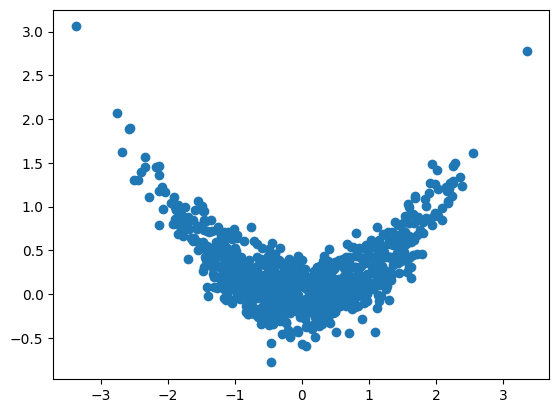

In [57]:
# Example 1: Banana
def sample_banana(n_samples=1000, sigma=1.0, noise=0.2):
    '''
    Samples a banana shaped-distribution.

    Args:
        n_samples (int): Number of samples.
        sigma (float): Standard Deviation of x-values of points.
        noise (float): Standard deviation of noise in y-values of points.
    '''
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

def log_rho_exact_banana(xy, sigma=1.0, noise=0.2):
    """
    Calculates the exact log-probability density for the banana distribution.
    
    Args:
        xy (np.ndarray): Array of 2D points with shape (n_samples, 2).
        sigma (float): Standard Deviation of x-values of points.
        noise (float): Standard deviation of noise in y-values of points.
        
    Returns:
        np.ndarray: The log-probability for each point.
    """
    x1 = xy[:, 0]
    x2 = xy[:, 1]
    
    log_p = (-np.log(2 * np.pi * sigma * noise) -
             (x1**2) / (2 * sigma**2) -
             (x2 - (x1**2) / 4)**2 / (2 * noise**2))
             
    return log_p

# Sample data
X = sample_banana()
plt.scatter(X[:,0], X[:,1])

# RBF Flow
print("RBF Flow Training\n")
flow = RBFConvexFlow(n_p=500, epsilon=0.08)
n_steps = 1000  # Number of steps to fit the model
flow.fit(x=X, log_rho_exact=log_rho_exact_banana, n_steps=n_steps)

samples = flow.sample(1000)  # Generate samples from the learned density model

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, label='Sampled Points')
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.5, color='red', label='Original Points')
plt.title('Samples from the RBF Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# ICNN Flow
print("\nICNN Flow Training")

In [72]:
def sample_banana(n_samples=10000, sigma=1.0, noise=0.2):
    '''
    Samples a banana shaped-distribution.

    Args:
        n_samples (int): Number of samples.
        sigma (float): Standard Deviation of x-values of points.
        noise (float): Standard deviation of noise in y-values of points.
    '''
    u = np.random.normal(0, sigma, size=n_samples)
    x1 = u
    x2 = (u**2)/4 + np.random.normal(0, noise, size=n_samples)
    return np.stack([x1, x2], axis=1)

def log_rho_exact_banana(xy, sigma=1.0, noise=0.2):
    """
    Calculates the exact log-probability density for the banana distribution.
    
    Args:
        xy (np.ndarray): Array of 2D points with shape (n_samples, 2).
        sigma (float): Standard Deviation of x-values of points.
        noise (float): Standard deviation of noise in y-values of points.
        
    Returns:
        np.ndarray: The log-probability for each point.
    """
    x1 = xy[:, 0]
    x2 = xy[:, 1]
    
    log_p = (-np.log(2 * np.pi * sigma * noise) -
             (x1**2) / (2 * sigma**2) -
             (x2 - (x1**2) / 4)**2 / (2 * noise**2))
             
    return log_p

# Sample data
X = sample_banana()
centers = train(X, model, epochs=200, lr=5e-2, dim=2, log_rho_exact=log_rho_exact_banana)

/tmp/ipykernel_1443/1228431970.py:177: UserWarning: brute force
  warnings.warn('brute force')


Epoch 5/200, NLL = 2.0924, KL = 0.7723
Epoch 10/200, NLL = 1.3257, KL = 0.0822
Epoch 15/200, NLL = 1.2747, KL = 0.0494
Epoch 20/200, NLL = 1.2646, KL = 0.0375


KeyboardInterrupt: 

/tmp/ipykernel_1443/1228431970.py:177: UserWarning: brute force
  warnings.warn('brute force')


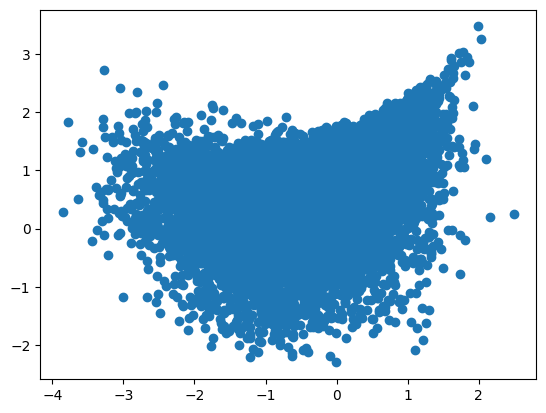

In [65]:
forward = model.forward_transform(torch.tensor(X, device=device, dtype=torch.float32), centers=centers)
plt.scatter(forward[0].cpu().detach().numpy()[:,0], forward[0].cpu().detach().numpy()[:,1])

In [73]:
samples = model.reverse(torch.randn(10000, 2, device=device), centers=centers).cpu().detach().numpy()  # Generate samples from the learned density model

/tmp/ipykernel_1443/1228431970.py:177: UserWarning: brute force
  warnings.warn('brute force')


Text(0.5, 1.0, 'Samples from the ICNN Model')

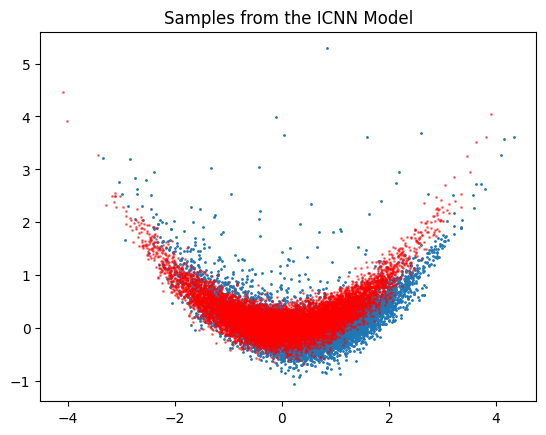

In [74]:
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=1, label='Sampled Points')
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.5, color='red', label='Original Points')
plt.title('Samples from the ICNN Model')